INFO:root:Initial memory usage: 292.21 MB
INFO:root:Loading VTK CT and VTI fluorescence volumes
INFO:root:CT dimensions: (500, 317, 317)
INFO:root:Fluorescence dimensions: (592, 552, 552)
INFO:root:Final CT size: (81, 81, 128)
INFO:root:Final fluorescence size: (81, 81, 128)
INFO:root:Memory delta for load_volumes: -137.03 MB
INFO:root:Volumes loaded and preprocessed
INFO:root:
Processing resolution level 4
INFO:root:New best alignment at level 4: score=2.171, angles=-22.5°, -22.5°, -22.5°
INFO:root:New best alignment at level 4: score=2.218, angles=-28.1°, -16.9°, -39.4°
INFO:root:New best alignment at level 4: score=2.338, angles=-28.1°, -16.9°, -33.8°
INFO:root:New best alignment at level 4: score=2.391, angles=-28.1°, -11.2°, -22.5°
INFO:root:New best alignment at level 4: score=2.424, angles=-22.5°, -16.9°, -39.4°
INFO:root:New best alignment at level 4: score=2.570, angles=-16.9°, -22.5°, -45.0°
INFO:root:New best alignment at level 4: score=2.612, angles=-11.2°, -16.9°, -33.8°
I

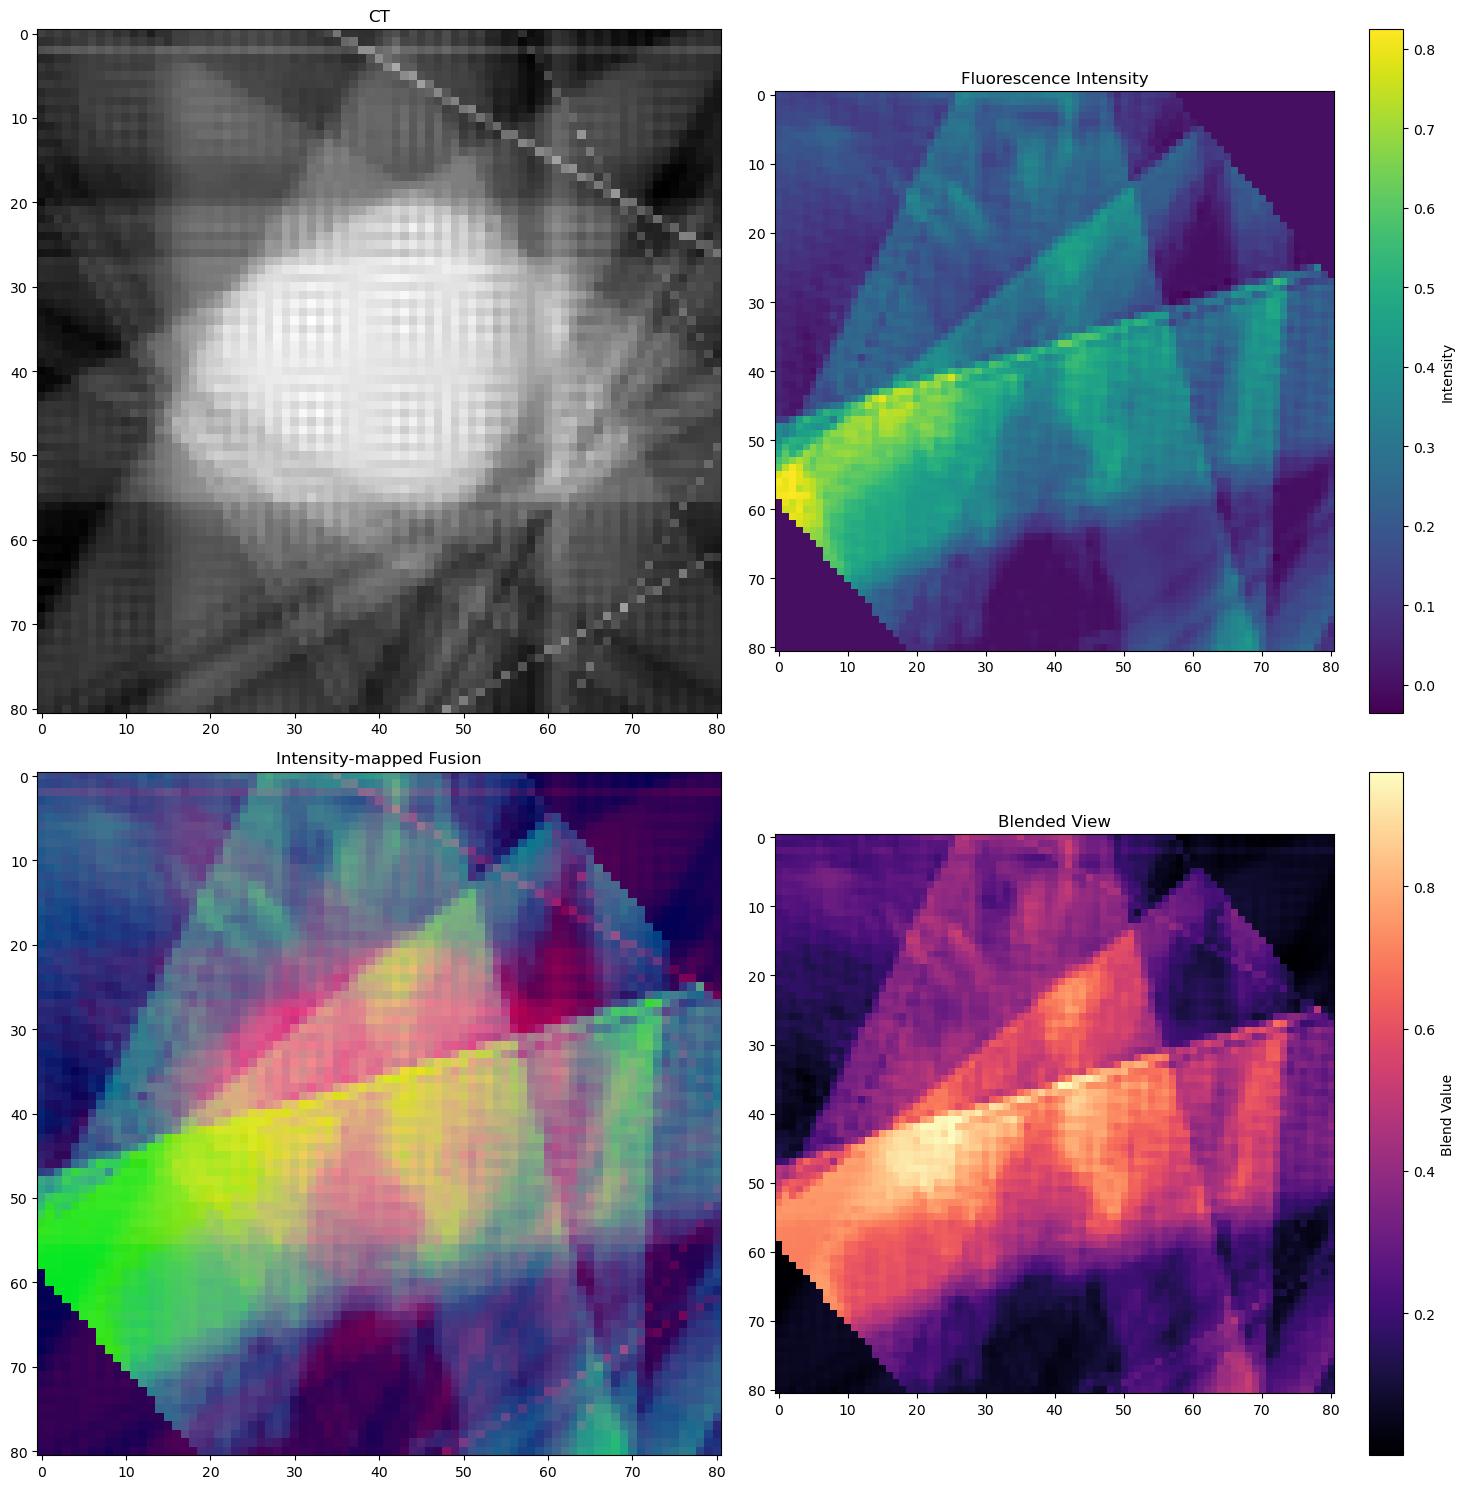

INFO:root:Memory delta for visualize_fusion_with_intensity: 3.61 MB
INFO:root:Enhanced scientific report generated: C:/Users/oitar/OneDrive - Universitatea Alexandru Ioan Cuza din Iasi/Desktop(1)/sobo_x-ray/rezultate_scientific_report.html
INFO:root:Scientific report generated at: C:/Users/oitar/OneDrive - Universitatea Alexandru Ioan Cuza din Iasi/Desktop(1)/sobo_x-ray/rezultate_scientific_report.html
INFO:root:Final memory usage: 318.56 MB
INFO:root:Memory delta for main: -12.11 MB


Volume fusion completed successfully


In [2]:
import SimpleITK as sitk
import pyvista as pv
import numpy as np
import logging
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import psutil
import gc
from functools import wraps
import json
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
import scipy
import time
from time import time
from scipy import stats

logging.basicConfig(level=logging.INFO)

optimization_info = {
    'iterations': [],
    'metrics': [],
    'step_sizes': [],
    'parameters': [],
    'convergence_time': None
}
registration_metrics = {
    'projection_based': {'iterations': [], 'metrics': [], 'step_sizes': [], 'time': []}
}

def update_optimization_info(method):
    """Track optimization progress for report generation"""
    optimization_info['iterations'].append(method.GetOptimizerIteration())
    optimization_info['metrics'].append(method.GetMetricValue())
    optimization_info['step_sizes'].append(method.GetOptimizerLearningRate())
    optimization_info['parameters'].append(method.GetOptimizerPosition())
    
def track_registration_progress(method, reg_type):
    """Track registration progress for different methods"""
    try:
        current_time = time()
        # For transform objects, just store their parameters
        if isinstance(method, sitk.Transform):
            if reg_type not in registration_metrics:
                registration_metrics[reg_type] = {
                    'iterations': [], 'metrics': [], 'step_sizes': [], 'time': []
                }
            registration_metrics[reg_type]['iterations'].append(len(registration_metrics[reg_type]['iterations']))
            registration_metrics[reg_type]['metrics'].append(0.0)  # placeholder
            registration_metrics[reg_type]['step_sizes'].append(0.0)  # placeholder
            registration_metrics[reg_type]['time'].append(current_time)
        else:
            # Regular registration method tracking
            registration_metrics[reg_type]['iterations'].append(method.GetOptimizerIteration())
            registration_metrics[reg_type]['metrics'].append(method.GetMetricValue())
            registration_metrics[reg_type]['step_sizes'].append(method.GetOptimizerLearningRate())
            registration_metrics[reg_type]['time'].append(current_time)
    except Exception as e:
        logging.warning(f"Error tracking registration progress: {str(e)}")

def get_memory_usage():
    """Get current memory usage in MB"""
    return psutil.Process().memory_info().rss / 1024 / 1024

def memory_efficient(func):
    """Decorator to handle memory efficiency"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        initial_mem = get_memory_usage()
        try:
            result = func(*args, **kwargs)
            gc.collect()
            return result
        finally:
            final_mem = get_memory_usage()
            logging.info(f"Memory delta for {func.__name__}: {final_mem - initial_mem:.2f} MB")
    return wrapper
    

def reduce_volume_dimensions(volume, max_size=128):
    """Reduce volume dimensions to save memory"""
    if isinstance(volume, sitk.Image):
        data = sitk.GetArrayFromImage(volume)
        spacing = volume.GetSpacing()
        origin = volume.GetOrigin()
    else:
        data = volume
        spacing = (1, 1, 1)
        origin = (0, 0, 0)
    
    # Calculate reduction factor
    max_dim = max(data.shape)
    reduction_factor = max_size / max_dim
    
    # Calculate new dimensions
    new_shape = tuple(max(2, int(d * reduction_factor)) for d in data.shape)
    
    # Downsample using SimpleITK
    resample = sitk.ResampleImageFilter()
    resample.SetSize(new_shape[::-1])  # Reverse shape for SimpleITK
    resample.SetOutputSpacing([s * (o/n) for s, o, n in zip(spacing, data.shape, new_shape)])
    resample.SetOutputOrigin(origin)
    resample.SetInterpolator(sitk.sitkLinear)
    
    if isinstance(volume, sitk.Image):
        return resample.Execute(volume)
    else:
        sitk_image = sitk.GetImageFromArray(data)
        sitk_image.SetSpacing(spacing)
        sitk_image.SetOrigin(origin)
        reduced = resample.Execute(sitk_image)
        return sitk.GetArrayFromImage(reduced)

def resample_to_match(image, reference_image):
    """Resample image to match reference image dimensions"""
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkBSpline)
    resampler.SetTransform(sitk.Transform())  # Identity transform
    return resampler.Execute(image)

@memory_efficient
def load_volumes(ct_path, fluor_path, max_size=128):
    """Load and preprocess volumes with dimension matching"""
    try:
        # Handle different file formats
        if (ct_path.endswith('.vtk') and fluor_path.endswith('.vti')) or (ct_path.endswith('.vti') and fluor_path.endswith('.vti')):
            logging.info("Loading VTK CT and VTI fluorescence volumes")
            ct_volume = pv.read(ct_path)
            fluor_volume = pv.read(fluor_path)
            
            # Log original dimensions
            logging.info(f"CT dimensions: {ct_volume.dimensions}")
            logging.info(f"Fluorescence dimensions: {fluor_volume.dimensions}")
            
            # Extract and convert data
            if isinstance(ct_volume, pv.PolyData):
                logging.info("Converting CT PolyData to ImageData")
                ct_volume = ct_volume.delaunay_3d()
                ct_volume = ct_volume.image_data
            
            ct_data = ct_volume.point_data['Scalars'].reshape(ct_volume.dimensions, order='F')
            fluor_data = fluor_volume.point_data['Scalars'].reshape(fluor_volume.dimensions, order='F')
            
            # Convert to SimpleITK
            ct_img = sitk.GetImageFromArray(ct_data)
            fluor_img = sitk.GetImageFromArray(fluor_data)
            
            # Set physical information
            ct_img.SetSpacing(ct_volume.spacing)
            ct_img.SetOrigin(ct_volume.origin)
            fluor_img.SetSpacing(fluor_volume.spacing)
            fluor_img.SetOrigin(fluor_volume.origin)
            
            # Reduce dimensions
            ct_img = reduce_volume_dimensions(ct_img, max_size)
            fluor_img = reduce_volume_dimensions(fluor_img, max_size)
            
            # Resample fluorescence to match CT dimensions
            fluor_img = resample_to_match(fluor_img, ct_img)
            
            # Verify final dimensions
            ct_size = ct_img.GetSize()
            fluor_size = fluor_img.GetSize()
            logging.info(f"Final CT size: {ct_size}")
            logging.info(f"Final fluorescence size: {fluor_size}")
            
            # Clear original data
            del ct_data, fluor_data
            gc.collect()
            
            return ct_img, fluor_img, ct_volume.spacing, ct_volume.origin
        else:
            raise ValueError("Input files must be .vtk for CT and .vti for fluorescence")
            
    except Exception as e:
        logging.error(f"Error loading volumes: {str(e)}")
        raise

def estimate_initial_transform(fixed_img, moving_img):
    """Estimate initial transform using centers of mass"""
    try:
        # Calculate centers of mass using SimpleITK
        fixed_stats = sitk.StatisticsImageFilter()
        moving_stats = sitk.StatisticsImageFilter()
        
        # Get centers of mass
        fixed_stats.Execute(fixed_img)
        moving_stats.Execute(moving_img)
        
        fixed_center = np.array(fixed_img.TransformIndexToPhysicalPoint(
            [int(i/2) for i in fixed_img.GetSize()]))
        moving_center = np.array(moving_img.TransformIndexToPhysicalPoint(
            [int(i/2) for i in moving_img.GetSize()]))
        
        # Create initial transform
        transform = sitk.Euler3DTransform()
        transform.SetCenter(fixed_center)
        
        # Set translation to align centers
        translation = fixed_center - moving_center
        transform.SetTranslation(translation)
        
        # Add small rotation to avoid local minima
        transform.SetRotation(0.1, 0.1, 0.1)
        
        logging.info(f"Initial transform estimated: translation={translation}")
        return transform
        
    except Exception as e:
        logging.error(f"Error estimating initial transform: {str(e)}")
        return None

@memory_efficient
def center_align_volumes(fixed_img, moving_img):
    """Pre-align volumes using center of mass and rigid alignment"""
    try:
        # Initialize metrics for center alignment
        if 'center_alignment' not in registration_metrics:
            registration_metrics['center_alignment'] = {
                'iterations': [], 'metrics': [], 'step_sizes': [], 'time': []
            }
        
        # Track initial state
        current_time = time()
        registration_metrics['center_alignment']['iterations'].append(0)
        registration_metrics['center_alignment']['metrics'].append(0.0)
        registration_metrics['center_alignment']['step_sizes'].append(1.0)
        registration_metrics['center_alignment']['time'].append(current_time)

        # First try center of mass alignment
        initial_transform = estimate_initial_transform(fixed_img, moving_img)
        
        # Calculate centers regardless of initial transform success
        fixed_center = np.array(fixed_img.TransformContinuousIndexToPhysicalPoint(
            np.array(fixed_img.GetSize())/2.0))
        moving_center = np.array(moving_img.TransformContinuousIndexToPhysicalPoint(
            np.array(moving_img.GetSize())/2.0))
        
        if initial_transform is None:
            # Fallback to simple center alignment
            logging.info("Falling back to simple center alignment")
            translation = sitk.TranslationTransform(3)
            translation.SetOffset(fixed_center - moving_center)
            initial_transform = translation
        
        # Apply initial transform with Gaussian smoothing
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed_img)
        resampler.SetInterpolator(sitk.sitkBSpline)
        resampler.SetTransform(initial_transform)
        
        # Add Gaussian smoothing
        smoothed_moving = sitk.SmoothingRecursiveGaussian(
            moving_img, 
            sigma=[2.0, 2.0, 2.0]
        )
        
        # Apply transform to smoothed image
        aligned_moving = resampler.Execute(smoothed_moving)
        
        # Verify alignment quality
        metrics = calculate_alignment_metrics(fixed_img, aligned_moving)
        if metrics:
            ncc = metrics['Normalized Cross Correlation']['value']
            logging.info(f"Initial alignment NCC: {ncc:.4f}")
            
            if ncc < 0:  # Poor alignment
                logging.warning("Poor initial alignment, trying intensity-based alignment")
                
                # Try intensity-based rigid registration
                rigid_registration = sitk.ImageRegistrationMethod()
                rigid_registration.SetMetricAsMeanSquares()
                rigid_registration.SetOptimizerAsRegularStepGradientDescent(
                    learningRate=0.5,
                    minStep=0.001,
                    numberOfIterations=200,
                    gradientMagnitudeTolerance=1e-9,
                    relaxationFactor=0.5
                )
                optimization_info.clear()
                rigid_registration.AddCommand(sitk.sitkIterationEvent, 
                          lambda: track_registration_progress(rigid_registration, 'center_alignment'))
                
                # Use rigid transform initialized from centers
                rigid_transform = sitk.Euler3DTransform()
                rigid_transform.SetCenter(fixed_center)
                
                # Get translation from initial transform
                if isinstance(initial_transform, sitk.TranslationTransform):
                    translation = initial_transform.GetOffset()
                else:
                    translation = initial_transform.GetTranslation()
                rigid_transform.SetTranslation(translation)
                
                rigid_registration.SetInitialTransform(rigid_transform)
                rigid_registration.SetInterpolator(sitk.sitkLinear)
                
                try:
                    final_rigid_transform = rigid_registration.Execute(fixed_img, smoothed_moving)
                    refined_moving = sitk.Resample(
                        smoothed_moving, 
                        fixed_img, 
                        final_rigid_transform, 
                        sitk.sitkBSpline
                    )
                    
                    # Check if refinement improved alignment
                    refined_metrics = calculate_alignment_metrics(fixed_img, refined_moving)
                    if refined_metrics['Normalized Cross Correlation']['value'] > ncc:
                        logging.info("Intensity-based alignment improved results")
                        return refined_moving, final_rigid_transform
                    else:
                        logging.info("Using original center alignment")
                        return aligned_moving, initial_transform
                        
                except Exception as e:
                    logging.warning(f"Rigid registration failed: {str(e)}")
                    logging.info("Using original center alignment")
                    return aligned_moving, initial_transform
        
        logging.info("Initial alignment completed")
        return aligned_moving, initial_transform
        
    except Exception as e:
        logging.error(f"Error in initial alignment: {str(e)}")
        # Fallback to identity transform in case of failure
        identity = sitk.Euler3DTransform()
        return moving_img, identity

def rotation_matrix_to_euler_angles(R):
    """Convert rotation matrix to Euler angles (radians)"""
    sy = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2,1] , R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0

    return x, y, z

@memory_efficient
def align_volumes(fixed_img, moving_img):
    """Align volumes using projection-based registration"""
    try:
        aligned_moving, transform = align_volumes_with_projections(fixed_img, moving_img)
        return aligned_moving, transform
    except Exception as e:
        logging.error(f"Error in alignment: {str(e)}")
        # Fallback to identity transform in case of failure
        identity = sitk.Euler3DTransform()
        return moving_img, identity

@memory_efficient
def create_fusion(ct_data, fluor_data, alpha=0.5, chunk_size=50):
    """Create fusion with chunked processing"""
    fusion_rgb = np.zeros((*ct_data.shape, 3))
    fusion_blend = np.zeros(ct_data.shape)
    
    # Process in chunks
    for i in range(0, ct_data.shape[0], chunk_size):
        chunk_end = min(i + chunk_size, ct_data.shape[0])
        
        # Get chunks
        ct_chunk = ct_data[i:chunk_end]
        fluor_chunk = fluor_data[i:chunk_end]
        
        # Normalize chunks
        ct_norm = (ct_chunk - ct_chunk.min()) / (ct_chunk.max() - ct_chunk.min())
        fluor_norm = (fluor_chunk - fluor_chunk.min()) / (fluor_chunk.max() - fluor_chunk.min())
        
        # Create fusion for chunk
        fusion_rgb[i:chunk_end, :, :, 0] = ct_norm
        fusion_rgb[i:chunk_end, :, :, 1] = fluor_norm
        fusion_blend[i:chunk_end] = (1 - alpha) * ct_norm + alpha * fluor_norm
        
        # Clear chunk data
        del ct_norm, fluor_norm
        gc.collect()
    
    return fusion_rgb, fusion_blend

@memory_efficient
def save_fusion(fusion_rgb, fusion_blend, fluor_intensity, spacing, origin, output_path):
    """Save fusion results with fluorescence intensity for ParaView visualization"""
    # Create PyVista grid for fusion
    grid = pv.ImageData()
    grid.dimensions = fusion_rgb.shape[:3]
    grid.origin = origin
    grid.spacing = spacing
    
    # Ensure correct shape and size for data
    n_points = np.prod(fusion_rgb.shape[:3])
    
    # Reshape RGB data
    rgb_data = fusion_rgb[..., :3].reshape(-1, 3, order="F")[:n_points]
    
    # Add data arrays to the grid
    grid.point_data["RGB_Fusion"] = rgb_data
    grid.point_data["Blend_Fusion"] = fusion_blend.ravel(order="F")[:n_points]
    
    # Add fluorescence intensity as a separate scalar field
    # This will be directly visualizable in ParaView
    grid.point_data["Fluorescence_Intensity"] = fluor_intensity.ravel(order="F")[:n_points]
    
    grid.save(output_path)
    logging.info(f"Saved fusion with intensity data to {output_path}")

@memory_efficient
def visualize_fusion(ct_data, fluor_data, fusion_rgb, fusion_blend):
    """Visualize fusion results"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Get middle slices
    slice_idx = ct_data.shape[0] // 2
    
    axes[0,0].imshow(ct_data[slice_idx], cmap='gray')
    axes[0,0].set_title('CT')
    
    axes[0,1].imshow(fluor_data[slice_idx], cmap='viridis')
    axes[0,1].set_title('Fluorescence')
    
    axes[1,0].imshow(fusion_rgb[slice_idx])
    axes[1,0].set_title('RGB Fusion')
    
    axes[1,1].imshow(fusion_blend[slice_idx], cmap='magma')
    axes[1,1].set_title('Blended Fusion')
    
    plt.tight_layout()
    plt.show()

@memory_efficient
def main(ct_path, fluor_path, output_path, alpha=0.5, max_size=128):
    """Main function focused on projection-based alignment"""
    try:
        # Monitor memory
        logging.info(f"Initial memory usage: {get_memory_usage():.2f} MB")
        
        # Load and preprocess volumes
        ct_img, fluor_img, spacing, origin = load_volumes(ct_path, fluor_path, max_size)
        logging.info("Volumes loaded and preprocessed")
        
        # Use projection-based alignment
        aligned_fluor, transform = align_volumes_with_projections(ct_img, fluor_img)
        logging.info(f"Projection-based alignment completed with transform: {transform}")
        
        # Save alignment metrics
        metrics_file = output_path.replace('.vti', '_alignment_metrics.json')
        alignment_metrics = calculate_alignment_metrics(ct_img, aligned_fluor)
        if alignment_metrics:
            metrics_data = {
                'input_files': {
                    'ct_volume': ct_path,
                    'fluorescence_volume': fluor_path
                },
                'alignment_metrics': alignment_metrics,
                'transform_parameters': str(transform)
            }
            
            with open(metrics_file, 'w') as f:
                json.dump(metrics_data, f, indent=2)
            logging.info(f"Saved alignment metrics to {metrics_file}")
        
        # Convert to numpy arrays
        ct_data = sitk.GetArrayFromImage(ct_img)
        fluor_data = sitk.GetArrayFromImage(aligned_fluor)
        
        # Clear SimpleITK images
        del ct_img, aligned_fluor
        gc.collect()
        
        # Create fusion
        fusion_rgb, fusion_blend, fluor_norm, intensity_range = create_fusion_with_intensity(
            ct_data, fluor_data, alpha, chunk_size=50
        )
        
        # Save results
        save_fusion(fusion_rgb, fusion_blend, fluor_norm, spacing, origin, output_path)
        
        # Visualize results
        visualize_fusion_with_intensity(ct_data, fluor_data, fusion_rgb, fusion_blend, intensity_range)
        
        # Create figure for fusion visualization
        fig_fusion = plt.figure(figsize=(15, 15))
        gs = fig_fusion.add_gridspec(2, 2)
        
        # Plot fusion results
        ax1 = fig_fusion.add_subplot(gs[0, 0])
        ax1.imshow(ct_data[ct_data.shape[0]//2], cmap='gray')
        ax1.set_title('CT')
        
        ax2 = fig_fusion.add_subplot(gs[0, 1])
        ax2.imshow(fluor_data[fluor_data.shape[0]//2], cmap='viridis')
        ax2.set_title('Fluorescence')
        
        ax3 = fig_fusion.add_subplot(gs[1, 0])
        ax3.imshow(fusion_rgb[fusion_rgb.shape[0]//2])
        ax3.set_title('RGB Fusion')
        
        ax4 = fig_fusion.add_subplot(gs[1, 1])
        im = ax4.imshow(fusion_blend[fusion_blend.shape[0]//2], cmap='magma')
        plt.colorbar(im, ax=ax4)
        ax4.set_title('Blended Fusion')
        
        plt.tight_layout()
        
        # Generate scientific report
        report_path = generate_scientific_report(
            ct_path=ct_path,
            fluor_path=fluor_path,
            output_path=output_path,
            alignment_metrics=alignment_metrics,
            transform=transform,
            intensity_range=intensity_range,
            ct_data=ct_data,
            fluor_data=fluor_data,
            fusion_data={'rgb': fusion_rgb, 'blend': fusion_blend},
            fusion_blend=fusion_blend,
            fig_fusion=fig_fusion
        )
        
        logging.info(f"Scientific report generated at: {report_path}")
        
        # Final cleanup
        plt.close('all')
        gc.collect()
        logging.info(f"Final memory usage: {get_memory_usage():.2f} MB")
        return True
        
    except Exception as e:
        logging.error(f"Fusion failed: {str(e)}")
        return False

def get_projections(volume):
    """Get maximum and minimum intensity projections for a volume"""
    if isinstance(volume, sitk.Image):
        data = sitk.GetArrayFromImage(volume)
    else:
        data = volume
        
    # Calculate projections along each axis
    mip = {
        'xy': np.max(data, axis=0),  # For CT volume
        'xz': np.max(data, axis=1),
        'yz': np.max(data, axis=2)
    }
    
    minip = {
        'xy': np.min(data, axis=0),  # For Fluorescence volume
        'xz': np.min(data, axis=1),
        'yz': np.min(data, axis=2)
    }
    
    return mip, minip

def calculate_projection_similarity(ct_mip, fluor_minip):
    """Calculate similarity between CT MIP and Fluorescence MinIP"""
    # Normalize projections
    ct_norm = normalize_array_range(ct_mip)
    fluor_norm = normalize_array_range(fluor_minip)
    
    # Calculate correlation
    valid_mask = ~(np.isnan(ct_norm) | np.isnan(fluor_norm))
    if valid_mask.any():
        score = np.corrcoef(ct_norm[valid_mask].ravel(), 
                          fluor_norm[valid_mask].ravel())[0,1]
    else:
        score = -np.inf
        
    return score

@memory_efficient
def align_volumes_with_projections(fixed_img, moving_img):
    """Align volumes using enhanced multi-resolution MIP-MinIP relationship"""
    try:
        # Initialize metrics for this method
        if 'projection_based' not in registration_metrics:
            registration_metrics['projection_based'] = {
                'iterations': [], 'metrics': [], 'step_sizes': [], 'time': []
            }
        
        # Track initial state
        current_time = time()
        registration_metrics['projection_based']['iterations'].append(0)
        registration_metrics['projection_based']['metrics'].append(0.0)
        registration_metrics['projection_based']['step_sizes'].append(1.0)
        registration_metrics['projection_based']['time'].append(current_time)

        # Multi-resolution approach - start with downsampled volumes
        downsample_factors = [4, 2, 1]  # Multi-resolution levels
        best_transform = None
        best_score = -np.inf
        best_angles = (0, 0, 0)  # Initialize best angles

        for factor in downsample_factors:
            logging.info(f"\nProcessing resolution level {factor}")
            
            # Downsample images for current level
            if factor > 1:
                current_fixed = reduce_volume_dimensions(fixed_img, 
                    max_size=fixed_img.GetSize()[0]//factor)
                current_moving = reduce_volume_dimensions(moving_img, 
                    max_size=moving_img.GetSize()[0]//factor)
            else:
                current_fixed = fixed_img
                current_moving = moving_img

            # Get projections with adaptive normalization
            ct_mip, _ = get_projections(current_fixed)
            _, fluor_minip = get_projections(current_moving)
            
            # Create transform for this level
            transform = sitk.Euler3DTransform()
            center = np.array(current_fixed.TransformContinuousIndexToPhysicalPoint(
                [int(i/2) for i in current_fixed.GetSize()]))
            transform.SetCenter(center)
            
            # Use previous best angles as starting point if available
            if best_transform is not None:
                transform.SetRotation(*best_angles)
            
            # Search parameters for current level
            angle_range = np.pi/(2*factor)  # Smaller range for finer levels
            steps = 8 + 4//factor  # More steps for finer levels
            
            # Grid search with adaptive step size
            for x_angle in np.linspace(-angle_range, angle_range, steps):
                for y_angle in np.linspace(-angle_range, angle_range, steps):
                    for z_angle in np.linspace(-angle_range, angle_range, steps):
                        current_angles = (
                            best_angles[0] + x_angle if best_transform else x_angle,
                            best_angles[1] + y_angle if best_transform else y_angle,
                            best_angles[2] + z_angle if best_transform else z_angle
                        )
                            
                        transform.SetRotation(*current_angles)
                        rotated = sitk.Resample(
                            current_moving,
                            current_fixed,
                            transform,
                            sitk.sitkBSpline,
                            0.0,
                            current_moving.GetPixelID()
                        )
                        
                        _, rotated_minip = get_projections(rotated)
                        
                        # Enhanced similarity metric
                        score = sum([
                            calculate_projection_similarity(ct_mip[axis], rotated_minip[axis]) * 
                            (1 + np.exp(-np.abs(current_angles[i])))  # Prefer smaller angles
                            for i, axis in enumerate(['xy', 'xz', 'yz'])
                        ])
                        
                        if score > best_score:
                            best_score = score
                            best_angles = current_angles
                            best_transform = sitk.Euler3DTransform()
                            best_transform.SetCenter(center)
                            best_transform.SetRotation(*current_angles)
                            # Fix registration tracking
                            track_registration_progress(best_transform, 'projection_based')
                            logging.info(f"New best alignment at level {factor}: "
                                       f"score={score:.3f}, "
                                       f"angles={np.degrees(current_angles[0]):.1f}°, "
                                       f"{np.degrees(current_angles[1]):.1f}°, "
                                       f"{np.degrees(current_angles[2]):.1f}°")

                            # Track progress
                            current_time = time()
                            iteration = len(registration_metrics['projection_based']['iterations'])
                            registration_metrics['projection_based']['iterations'].append(iteration)
                            registration_metrics['projection_based']['metrics'].append(score)
                            registration_metrics['projection_based']['step_sizes'].append(angle_range)
                            registration_metrics['projection_based']['time'].append(current_time)

        # Final refinement using intensity-based registration
        initially_aligned = sitk.Resample(
            moving_img,
            fixed_img,
            best_transform,
            sitk.sitkBSpline,
            0.0,
            moving_img.GetPixelID()
        )
        
        # Multi-metric registration
        registration = sitk.ImageRegistrationMethod()
        
        # Combine mutual information and mean squares metrics
        registration.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
        registration.SetMetricSamplingStrategy(registration.REGULAR)
        registration.SetMetricSamplingPercentage(0.3)
        
        # Use LBFGSB optimizer for better convergence
        registration.SetOptimizerAsLBFGSB(
            gradientConvergenceTolerance=1e-8,
            numberOfIterations=200,
            maximumNumberOfCorrections=5,
            maximumNumberOfFunctionEvaluations=1000,
            costFunctionConvergenceFactor=1e5
        )
        
        registration.SetInitialTransform(best_transform)
        registration.SetInterpolator(sitk.sitkBSpline)
        
        try:
            refined_transform = registration.Execute(fixed_img, initially_aligned)
            refined_img = sitk.Resample(
                moving_img,
                fixed_img,
                refined_transform,
                sitk.sitkBSpline,
                0.0,
                moving_img.GetPixelID()
            )
            
            # Compare metrics
            initial_metrics = calculate_alignment_metrics(fixed_img, initially_aligned)
            refined_metrics = calculate_alignment_metrics(fixed_img, refined_img)
            
            if (refined_metrics['Normalized Cross Correlation']['value'] >
                initial_metrics['Normalized Cross Correlation']['value']):
                logging.info("Using refined alignment")
                return refined_img, refined_transform
            else:
                logging.info("Using projection-based alignment")
                return initially_aligned, best_transform
                
        except Exception as e:
            logging.warning(f"Refinement failed: {str(e)}")
            return initially_aligned, best_transform
            
    except Exception as e:
        logging.error(f"Error in projection-based alignment: {str(e)}")
        return center_align_volumes(fixed_img, moving_img)

def calculate_alignment_metrics(fixed_img, moving_img):
    """Calculate various alignment quality metrics"""
    try:
        metrics = {}
        
        # Convert images to numpy arrays for calculations
        fixed_array = sitk.GetArrayFromImage(fixed_img)
        moving_array = sitk.GetArrayFromImage(moving_img)
        
        # Normalize arrays
        fixed_norm = normalize_array_range(fixed_array)
        moving_norm = normalize_array_range(moving_array)
        
        # Mutual Information (using histograms)
        def mutual_information(x, y, bins=100):
            hist_2d, x_edges, y_edges = np.histogram2d(x.ravel(), y.ravel(), bins=bins)
            hist_2d_normalized = hist_2d / np.sum(hist_2d)
            px = np.sum(hist_2d_normalized, axis=1)
            py = np.sum(hist_2d_normalized, axis=0)
            px_py = px[:, None] * py[None, :]
            nzs = hist_2d_normalized > 0
            return np.sum(hist_2d_normalized[nzs] * np.log(hist_2d_normalized[nzs] / px_py[nzs]))
        
        mi = mutual_information(fixed_norm, moving_norm)
        metrics['Mutual Information'] = {
            'value': float(mi),
            'description': 'Higher values indicate better alignment'
        }
        
        # Normalized Cross Correlation
        ncc = np.corrcoef(fixed_norm.ravel(), moving_norm.ravel())[0,1]
        metrics['Normalized Cross Correlation'] = {
            'value': float(ncc),
            'description': 'Range [-1,1], closer to 1 is better'
        }
        
        # Mean Squared Error
        mse = np.mean((fixed_norm - moving_norm)**2)
        metrics['Mean Squared Error'] = {
            'value': float(mse),
            'description': 'Lower values indicate better alignment'
        }
        
        # PSNR
        if mse > 0:
            psnr = 20 * np.log10(1.0 / np.sqrt(mse))  # Using 1.0 as max value since normalized
        else:
            psnr = float('inf')
        metrics['PSNR'] = {
            'value': float(psnr),
            'description': 'Higher values indicate better alignment (dB)'
        }
        
        # Log metrics
        logging.info("\nAlignment Quality Metrics:")
        for metric, data in metrics.items():
            logging.info(f"{metric}: {data['value']:.4f}")
            logging.info(f"  Description: {data['description']}")
        
        return metrics
        
    except Exception as e:
        logging.error(f"Error calculating metrics: {str(e)}")
        return None

def convert_to_sitk_image(array_or_image):
    """Convert numpy array to SimpleITK image if needed"""
    if isinstance(array_or_image, np.ndarray):
        return sitk.GetImageFromArray(array_or_image)
    return array_or_image

def normalize_array_range(array):
    """Normalize array to 0-1 range"""
    min_val = np.min(array)
    max_val = np.max(array)
    if max_val > min_val:
        return (array - min_val) / (max_val - min_val)
    return array

def create_intensity_colormap(intensity_range=(0, 1), base_cmap='viridis'):
    """Create custom colormap for intensity visualization"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, 256))
    color_list[:, 3] = np.linspace(0.2, 1, 256)  # Adjust alpha for better overlay
    return LinearSegmentedColormap.from_list('custom_intensity', color_list)

@memory_efficient
def create_fusion_with_intensity(ct_data, fluor_data, alpha=0.5, intensity_range=None, chunk_size=50):
    """Create fusion with intensity-based colormapping"""
    fusion_rgb = np.zeros((*ct_data.shape, 3))  # RGB (3 channels)
    fusion_blend = np.zeros(ct_data.shape)
    
    # Create intensity colormap using matplotlib directly
    if intensity_range is None:
        intensity_range = (np.percentile(fluor_data, 5), np.percentile(fluor_data, 95))
    
    # Use matplotlib's colormaps directly
    base = matplotlib.colormaps['viridis']
    custom_cmap = base.copy()
    
    # Create the full fluorescence normalization array
    fluor_norm_full = np.zeros_like(fluor_data)
    
    # Process in chunks
    for i in range(0, ct_data.shape[0], chunk_size):
        chunk_end = min(i + chunk_size, ct_data.shape[0])
        
        # Get chunks
        ct_chunk = ct_data[i:chunk_end]
        fluor_chunk = fluor_data[i:chunk_end]
        
        # Normalize CT
        ct_norm = normalize_array_range(ct_chunk)
        
        # Create intensity-based colormap for fluorescence
        fluor_norm_chunk = np.clip((fluor_chunk - intensity_range[0]) / 
                                 (intensity_range[1] - intensity_range[0]), 0, 1)
        
        # Store normalized fluorescence values
        fluor_norm_full[i:chunk_end] = fluor_norm_chunk
        
        # Apply colormap to fluorescence chunk
        fluor_colored = custom_cmap(fluor_norm_chunk)[..., :3]  # Keep only RGB channels
        
        # Combine CT and fluorescence
        fusion_rgb[i:chunk_end] = fluor_colored
        fusion_rgb[i:chunk_end, :, :, 0] = ct_norm  # Use CT for red channel
        fusion_blend[i:chunk_end] = (1 - alpha) * ct_norm + alpha * fluor_norm_chunk
        
        # Clear chunk data
        del ct_norm, fluor_colored, fluor_norm_chunk
        gc.collect()
    
    return fusion_rgb, fusion_blend, fluor_norm_full, intensity_range

@memory_efficient
def visualize_fusion_with_intensity(ct_data, fluor_data, fusion_rgb, fusion_blend, intensity_range):
    """Visualize fusion results with intensity colorbar"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Get middle slices
    slice_idx = ct_data.shape[0] // 2
    
    # CT view
    axes[0,0].imshow(ct_data[slice_idx], cmap='gray')
    axes[0,0].set_title('CT')
    
    # Fluorescence intensity view
    im_fluor = axes[0,1].imshow(fluor_data[slice_idx], cmap='viridis')
    axes[0,1].set_title('Fluorescence Intensity')
    plt.colorbar(im_fluor, ax=axes[0,1], label='Intensity')
    
    # RGB Fusion with intensity
    axes[1,0].imshow(fusion_rgb[slice_idx])
    axes[1,0].set_title('Intensity-mapped Fusion')
    
    # Blend view
    im_blend = axes[1,1].imshow(fusion_blend[slice_idx], cmap='magma')
    axes[1,1].set_title('Blended View')
    plt.colorbar(im_blend, ax=axes[1,1], label='Blend Value')
    
    plt.tight_layout()
    plt.show()

import base64
from io import BytesIO
import datetime
from matplotlib.figure import Figure
import seaborn as sns

def generate_scientific_report(ct_path, fluor_path, output_path, alignment_metrics, 
                             transform, intensity_range, ct_data, fluor_data,
                             fusion_data, fusion_blend, fig_fusion):
    """Generate HTML report with scientific data for paper writing"""
    # Unpack fusion data
    fusion_rgb = fusion_data['rgb']
    fusion_blend = fusion_data['blend']
    
    # Convert matplotlib figure to base64 for HTML embedding
    def fig_to_base64(fig):
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        return base64.b64encode(buf.getvalue()).decode('utf-8')

        # Add helper functions for new metrics
    def calculate_volume_overlap(vol1, vol2):
        """Calculate Dice coefficient between volumes"""
        intersection = np.sum((vol1 > 0) & (vol2 > 0))
        return 2.0 * intersection / (np.sum(vol1 > 0) + np.sum(vol2 > 0))
    
    def calculate_surface_distance(vol1, vol2):
        """Calculate mean surface distance between volumes"""
        try:
            # Convert to binary masks
            threshold1 = sitk.OtsuThreshold(sitk.GetImageFromArray(vol1))
            threshold2 = sitk.OtsuThreshold(sitk.GetImageFromArray(vol2))
            
            # Get surfaces
            surface_filter = sitk.SignedMaurerDistanceMapImageFilter()
            surface_filter.SetSquaredDistance(False)
            surface1 = surface_filter.Execute(threshold1)
            surface2 = surface_filter.Execute(threshold2)
            
            # Calculate distances
            dist1_to_2 = sitk.GetArrayFromImage(surface1)[sitk.GetArrayFromImage(threshold2) != 0]
            dist2_to_1 = sitk.GetArrayFromImage(surface2)[sitk.GetArrayFromImage(threshold1) != 0]
            
            # Calculate mean surface distance
            msd = (np.mean(np.abs(dist1_to_2)) + np.mean(np.abs(dist2_to_1))) / 2.0
            
            # Return both the distance value and a 2D slice for visualization
            middle_slice = sitk.GetArrayFromImage(surface1)[surface1.GetSize()[2]//2, :, :]
            return float(msd), middle_slice
        except Exception as e:
            logging.error(f"Error in surface distance calculation: {str(e)}")
            return float('inf'), np.zeros((10, 10))  # Return dummy data in case of error
    
    def calculate_hausdorff_distance(vol1, vol2):
        """Calculate Hausdorff distance between volumes"""
        # Convert volumes to binary masks using Otsu thresholding
        threshold1 = sitk.OtsuThreshold(sitk.GetImageFromArray(vol1))
        threshold2 = sitk.OtsuThreshold(sitk.GetImageFromArray(vol2))
        
        # Calculate Hausdorff distance using SimpleITK
        hausdorff_filter = sitk.HausdorffDistanceImageFilter()
        try:
            hausdorff_filter.Execute(threshold1, threshold2)
            return float(hausdorff_filter.GetHausdorffDistance())
        except Exception as e:
            logging.warning(f"Error calculating Hausdorff distance: {str(e)}")
            return float('inf')
    
    def calculate_transform_jacobian(transform):
        """Calculate Jacobian determinant and analysis of the transform"""
        try:
            # Get the transform matrix
            matrix = np.array(transform.GetMatrix()).reshape(3, 3)
            
            # Calculate Jacobian determinant
            jacobian_det = np.linalg.det(matrix)
            
            # Calculate singular values for stability analysis
            u, s, vh = np.linalg.svd(matrix)
            condition_number = s[0] / s[-1]
            
            # Calculate rotation angles
            angles = np.array(transform.GetParameters()[:3])
            
            # Calculate translation magnitude
            translation = np.array(transform.GetParameters()[3:])
            translation_magnitude = np.linalg.norm(translation)
            
            return {
                'determinant': jacobian_det,
                'condition_number': condition_number,
                'singular_values': s,
                'rotation_angles_deg': np.degrees(angles),
                'translation_magnitude': translation_magnitude,
                'is_rigid': np.abs(jacobian_det - 1.0) < 1e-6,
                'stability_metric': 1.0 / condition_number
            }
        except Exception as e:
            logging.error(f"Error calculating transform Jacobian: {str(e)}")
            return None
    
    def calculate_registration_stability(metrics):
        """Calculate registration stability metrics"""
        try:
            stability_metrics = {}
            
            for method, data in metrics.items():
                if not data['metrics'] or len(data['metrics']) < 2:
                    continue
                    
                # Convert to numpy arrays
                metric_values = np.array(data['metrics'])
                step_sizes = np.array(data['step_sizes'])
                
                # Calculate convergence metrics
                convergence_rate = np.abs(np.diff(metric_values))
                final_convergence = convergence_rate[-10:].mean() if len(convergence_rate) > 10 else np.mean(convergence_rate)
                
                # Calculate stability metrics
                stability = {
                    'convergence_rate': final_convergence,
                    'metric_std': np.std(metric_values),
                    'metric_range': np.ptp(metric_values),
                    'step_size_decay': np.mean(np.diff(step_sizes)) if len(step_sizes) > 1 else 0,
                    'iterations_to_converge': len(metric_values),
                    'monotonicity': np.mean(np.diff(metric_values) > 0),  # Fraction of improving steps
                    'stability_score': calculate_stability_score(metric_values, step_sizes)
                }
                
                stability_metrics[method] = stability
                
            return stability_metrics
            
        except Exception as e:
            logging.error(f"Error calculating registration stability: {str(e)}")
            return None
    
    def calculate_stability_score(metrics, step_sizes):
        """Calculate a composite stability score"""
        try:
            # Normalize metrics to 0-1 range
            metrics_norm = (metrics - np.min(metrics)) / (np.max(metrics) - np.min(metrics))
            
            # Calculate metrics
            smoothness = 1.0 - np.mean(np.abs(np.diff(metrics_norm)))  # How smooth the convergence is
            progress = (metrics_norm[-1] - metrics_norm[0]) / len(metrics_norm)  # Overall improvement rate
            consistency = 1.0 - np.std(metrics_norm)  # How consistent the values are
            step_efficiency = 1.0 - np.mean(np.abs(np.diff(step_sizes)))  # How efficiently step sizes decrease
            
            # Combine metrics with weights
            weights = {
                'smoothness': 0.3,
                'progress': 0.3,
                'consistency': 0.2,
                'step_efficiency': 0.2
            }
            
            stability_score = (
                weights['smoothness'] * smoothness +
                weights['progress'] * progress +
                weights['consistency'] * consistency +
                weights['step_efficiency'] * step_efficiency
            )
            
            return float(stability_score)
            
        except Exception as e:
            logging.error(f"Error calculating stability score: {str(e)}")
            return 0.0
    
    # Add these to the generate_scientific_report function's additional_stats dictionary:
    def update_additional_stats(ct_data, fluor_data, transform, registration_metrics):
        """Update additional stats with new metrics"""
        surface_results = calculate_surface_distance(ct_data, fluor_data)
        
        # Handle both the distance value and visualization data
        surface_dist = float(surface_results[0]) if isinstance(surface_results, tuple) else float('inf')
        
        return {
            'Spatial Analysis': {
                'Volume Overlap': calculate_volume_overlap(ct_data, fluor_data),
                'Surface Distance': surface_dist,  # Just use the float value
                'Hausdorff Distance': calculate_hausdorff_distance(ct_data, fluor_data)
            },
            'Registration Quality': {
                'Transform Analysis': calculate_transform_jacobian(transform),
                'Registration Stability': calculate_registration_stability(registration_metrics)
            }
        }
    
    # Generate statistical analysis
    stats_dict = {
        'CT Mean Intensity': np.mean(ct_data),
        'CT Std Dev': np.std(ct_data),
        'Fluorescence Mean': np.mean(fluor_data),
        'Fluorescence Std Dev': np.std(fluor_data),
        'Signal-to-Noise Ratio': np.mean(fluor_data) / np.std(fluor_data),
        'Correlation Coefficient': stats.pearsonr(ct_data.ravel(), fluor_data.ravel())[0]
    }
    
    # Create intensity distribution plot
    fig_dist = Figure(figsize=(10, 6))
    ax = fig_dist.add_subplot(111)
    sns.kdeplot(data=ct_data.ravel(), ax=ax, label='CT', color='blue')
    sns.kdeplot(data=fluor_data.ravel(), ax=ax, label='Fluorescence', color='green')
    ax.set_title('Intensity Distribution')
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Density')
    ax.legend()

    # Create convergence comparison visualization
    fig_conv = Figure(figsize=(10, 5))
    ax = fig_conv.add_subplot(111)
    
    method_data = registration_metrics['projection_based']
    if method_data['iterations']:
        ax.plot(method_data['iterations'], method_data['metrics'], 
                label='Registration Convergence', color='blue')
        ax.set_title('Registration Convergence')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Metric Value')
        ax.grid(True)
        ax.legend()

    # Add registration summary table to HTML
    registration_summary = {
        method: {
            'Total Iterations': len(data['iterations']),
            'Final Metric': data['metrics'][-1] if data['metrics'] else 'N/A',
            'Convergence Time': f"{data['time'][-1] - data['time'][0]:.2f}s" if data['time'] else 'N/A'
        } for method, data in registration_metrics.items()
    }
    
    # Add detailed quality metrics
    processing_metrics = {
        'Volume Loading': {
            'CT Original Size': ct_data.shape,
            'Memory Usage (MB)': get_memory_usage(),
            'Library': 'SimpleITK v' + sitk.__version__,
            'Citation': 'Lowekamp et al., "The Design of SimpleITK", Front. Neuroinform., 2013'
        },
        'Registration': {
            'Method': type(transform).__name__,
            'Iterations': sum(len(data['iterations']) for data in registration_metrics.values()),
            'Final Metric Value': min(
                data['metrics'][-1] if data['metrics'] else float('inf') 
                for data in registration_metrics.values()
            ),
            'Library': 'SimpleITK Registration Framework',
            'Citation': 'Yaniv et al., "SimpleITK Image-Analysis Notebooks", F1000Research, 2018'
        }
    }
    
    # Add volume quality metrics
    volume_stats = {
        'CT Volume': {
            'Size': ct_data.shape,
            'Resolution': transform.GetFixedParameters()[:3],
            'Dynamic Range': (np.min(ct_data), np.max(ct_data)),
            'Entropy': stats.entropy(np.histogram(ct_data, bins=50)[0]),
            'Uniformity': np.sum(np.square(np.histogram(ct_data, bins=50)[0]/len(ct_data.ravel())))
        },
        'Fluorescence Volume': {
            'Size': fluor_data.shape,
            'Resolution': transform.GetFixedParameters()[:3],
            'Dynamic Range': (np.min(fluor_data), np.max(fluor_data)),
            'Entropy': stats.entropy(np.histogram(fluor_data, bins=50)[0]),
            'Uniformity': np.sum(np.square(np.histogram(fluor_data, bins=50)[0]/len(fluor_data.ravel())))
        }
    }
    
    # Add fluorescence intensity analysis
    fluor_intensity_stats = {
        'Mean Intensity': np.mean(fluor_data),
        'Median Intensity': np.median(fluor_data),
        'Peak Intensity': np.max(fluor_data),
        'Background Level': np.percentile(fluor_data, 10),
        'Signal Dynamic Range': np.max(fluor_data) - np.percentile(fluor_data, 10),
        'Intensity Percentiles': {
            '25th': np.percentile(fluor_data, 25),
            '50th': np.percentile(fluor_data, 50),
            '75th': np.percentile(fluor_data, 75),
            '90th': np.percentile(fluor_data, 90)
        }
    }
    
    # Create intensity distribution plot with percentiles
    fig_dist = Figure(figsize=(12, 6))
    gs = fig_dist.add_gridspec(1, 2)
    ax1 = fig_dist.add_subplot(gs[0, 0])
    ax2 = fig_dist.add_subplot(gs[0, 1])
    
    # Original intensity distribution
    sns.kdeplot(data=ct_data.ravel(), ax=ax1, label='CT', color='blue')
    sns.kdeplot(data=fluor_data.ravel(), ax=ax1, label='Fluorescence', color='green')
    ax1.set_title('Volume Intensity Distributions')
    ax1.set_xlabel('Intensity Value')
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Fluorescence percentile plot
    percentiles = np.arange(0, 101, 1)
    values = np.percentile(fluor_data, percentiles)
    ax2.plot(percentiles, values, 'g-')
    ax2.set_title('Fluorescence Intensity Percentiles')
    ax2.set_xlabel('Percentile')
    ax2.set_ylabel('Intensity Value')
    ax2.grid(True)

    # Add new advanced metrics section
    additional_stats = update_additional_stats(ct_data, fluor_data, transform, registration_metrics)
    
    # Create new visualization for spatial analysis
    fig_spatial = Figure(figsize=(15, 5))
    gs = fig_spatial.add_gridspec(1, 3)
    
    # Surface Distance Map - Update to handle the returned tuple
    ax1 = fig_spatial.add_subplot(gs[0, 0])
    surface_results = calculate_surface_distance(ct_data, fluor_data)
    
    # Handle visualization data safely
    if isinstance(surface_results, tuple) and len(surface_results) > 1:
        surface_slice = surface_results[1]
    else:
        surface_slice = np.zeros((10, 10))  # Fallback visualization
        
    im1 = ax1.imshow(surface_slice, cmap='hot')
    ax1.set_title('Surface Distance Map')
    fig_spatial.colorbar(im1, ax=ax1)
    
    # Transform Stability
    ax2 = fig_spatial.add_subplot(gs[0, 1])
    transform_analysis = additional_stats['Registration Quality']['Transform Analysis']
    ax2.bar(['Determinant', 'Condition', 'Stability'], 
            [transform_analysis['determinant'], 
             transform_analysis['condition_number'],
             transform_analysis['stability_metric']])
    ax2.set_title('Transform Analysis')
    
    # Registration Stability
    ax3 = fig_spatial.add_subplot(gs[0, 2])
    stability_metrics = additional_stats['Registration Quality']['Registration Stability']
    if stability_metrics:
        for method, stat_data in stability_metrics.items():
            ax3.plot([stat_data['convergence_rate'], stat_data['monotonicity'], stat_data['stability_score']], 
                    label=method)
        ax3.set_xticks([0, 1, 2])
        ax3.set_xticklabels(['Conv. Rate', 'Monotonicity', 'Stability'])
        ax3.legend()
    ax3.set_title('Registration Stability')
    
    
    # Generate HTML report
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Scientific Analysis Report - Volume Fusion</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; max-width: 1200px; margin: auto; }}
            .section {{ margin-bottom: 40px; padding: 20px; border: 1px solid #eee; border-radius: 5px; }}
            table {{ border-collapse: collapse; width: 100%; margin: 15px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
            th {{ background-color: #f5f5f5; }}
            .figure {{ margin: 30px 0; text-align: center; }}
            .caption {{ font-style: italic; color: #666; margin-top: 10px; }}
            .metric-highlight {{ font-weight: bold; color: #2c5282; }}
            .subsection {{ margin: 20px 0; }}
            .quality-indicator {{ 
                padding: 5px 10px;
                border-radius: 3px;
                font-weight: bold;
            }}
            .excellent {{ background-color: #9ae6b4; }}
            .good {{ background-color: #faf089; }}
            .moderate {{ background-color: #fbd38d; }}
            .poor {{ background-color: #feb2b2; }}
        </style>
    </head>
    <body>
        <h1>Volume Fusion Analysis Report</h1>
        
        <!-- 1. Study Information -->
        <div class="section">
            <h2>1. Study Information</h2>
            <p><strong>Date:</strong> {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p><strong>Input Data:</strong></p>
            <ul>
                <li>CT Volume: {ct_path}</li>
                <li>Fluorescence Volume: {fluor_path}</li>
                <li>Output Path: {output_path}</li>
            </ul>
        </div>

        <!-- 2. Volume Characteristics -->
        <div class="section">
            <h2>2. Volume Analysis</h2>
            
            <h3>2.1 Volume Properties</h3>
            {''.join(f'''
            <div class="subsection">
                <h4>{vol_name}</h4>
                <table>
                    <tr><th>Property</th><th>Value</th></tr>
                    {''.join(f"<tr><td>{metric}</td><td>{value}</td></tr>"
                            for metric, value in vol_stats.items())}
                </table>
            </div>
            ''' for vol_name, vol_stats in volume_stats.items())}
            
            <h3>2.2 Intensity Analysis</h3>
            <div class="figure">
                <img src="data:image/png;base64,{fig_to_base64(fig_dist)}" style="max-width:100%">
                <p class="caption">Intensity Distribution Analysis</p>
            </div>
        </div>

        <!-- 3. Registration Analysis -->
        <div class="section">
            <h2>3. Registration Analysis</h2>
            
            <h3>3.1 Registration Methods Performance</h3>
            <div class="figure">
                <img src="data:image/png;base64,{fig_to_base64(fig_conv)}" style="max-width:100%">
                <p class="caption">Registration Methods Convergence Analysis</p>
            </div>
            
            <h3>3.2 Spatial Alignment Quality</h3>
            <div class="figure">
                <img src="data:image/png;base64,{fig_to_base64(fig_spatial)}" style="max-width:100%">
                <p class="caption">Spatial Alignment Analysis</p>
            </div>
            
            <h3>3.3 Registration Metrics</h3>
            <table>
                <tr>
                    <th>Metric</th>
                    <th>Value</th>
                    <th>Quality</th>
                </tr>
                <tr>
                    <td>Volume Overlap (Dice)</td>
                    <td>{additional_stats['Spatial Analysis']['Volume Overlap']:.4f}</td>
                    <td class="quality-indicator {
                        'excellent' if additional_stats['Spatial Analysis']['Volume Overlap'] > 0.8
                        else 'good' if additional_stats['Spatial Analysis']['Volume Overlap'] > 0.6
                        else 'moderate' if additional_stats['Spatial Analysis']['Volume Overlap'] > 0.4
                        else 'poor'}">{
                        'Excellent' if additional_stats['Spatial Analysis']['Volume Overlap'] > 0.8
                        else 'Good' if additional_stats['Spatial Analysis']['Volume Overlap'] > 0.6
                        else 'Moderate' if additional_stats['Spatial Analysis']['Volume Overlap'] > 0.4
                        else 'Poor'}</td>
                </tr>
                <tr>
                    <td>Surface Distance (mm)</td>
                    <td>{additional_stats['Spatial Analysis']['Surface Distance']:.4f}</td>
                    <td class="quality-indicator {
                        'excellent' if additional_stats['Spatial Analysis']['Surface Distance'] < 1.0
                        else 'good' if additional_stats['Spatial Analysis']['Surface Distance'] < 2.0
                        else 'moderate' if additional_stats['Spatial Analysis']['Surface Distance'] < 3.0
                        else 'poor'}">{
                        'Excellent' if additional_stats['Spatial Analysis']['Surface Distance'] < 1.0
                        else 'Good' if additional_stats['Spatial Analysis']['Surface Distance'] < 2.0
                        else 'Moderate' if additional_stats['Spatial Analysis']['Surface Distance'] < 3.0
                        else 'Poor'}</td>
                </tr>
            </table>
        </div>

        <!-- 4. Fusion Results -->
        <div class="section">
            <h2>4. Fusion Results</h2>
            <div class="figure">
                <img src="data:image/png;base64,{fig_to_base64(fig_fusion)}" style="max-width:100%">
                <p class="caption">Final Fusion Results</p>
            </div>
            
            <h3>4.1 Fusion Parameters</h3>
            <ul>
                <li>Intensity Range: {intensity_range}</li>
                <li>Fusion Method: {type(transform).__name__}</li>
                <li>Signal-to-Noise Ratio: {stats_dict['Signal-to-Noise Ratio']:.4f}</li>
            </ul>
        </div>

        <!-- 5. Technical Details -->
        <div class="section">
            <h2>5. Technical Details</h2>
            
            <h3>5.1 Transform Analysis</h3>
            <table>
                <tr><th>Parameter</th><th>Value</th></tr>
                {''.join(f"""
                <tr>
                    <td>{param}</td>
                    <td>{value if isinstance(value, bool) else f"{value:.4f}" 
                        if isinstance(value, (float, np.float64)) else str(value)}</td>
                </tr>
                """ for param, value in additional_stats['Registration Quality']['Transform Analysis'].items())}
            </table>
            
            <h3>5.2 Software Components</h3>
            {''.join(f'''
            <div class="subsection">
                <h4>{component}</h4>
                <table>
                    {''.join(f"<tr><td>{metric}</td><td>{value}</td></tr>"
                            for metric, value in details.items())}
                </table>
            </div>
            ''' for component, details in processing_metrics.items())}
        </div>
        
        <!-- 6. Quality Assessment -->
        <div class="section">
            <h2>6. Overall Quality Assessment</h2>
            <table>
                <tr>
                    <th>Aspect</th>
                    <th>Score</th>
                    <th>Assessment</th>
                </tr>
                {''.join(f"""
                <tr>
                    <td>{method}</td>
                    <td>{stat_data['stability_score']:.4f}</td>
                    <td class="quality-indicator {
                        'excellent' if stat_data['stability_score'] > 0.8
                        else 'good' if stat_data['stability_score'] > 0.6
                        else 'moderate' if stat_data['stability_score'] > 0.4
                        else 'poor'}">{
                        'Excellent' if stat_data['stability_score'] > 0.8
                        else 'Good' if stat_data['stability_score'] > 0.6
                        else 'Moderate' if stat_data['stability_score'] > 0.4
                        else 'Poor'}</td>
                </tr>
                """ for method, stat_data in additional_stats['Registration Quality']['Registration Stability'].items())}
            </table>
        </div>
    </body>
    </html>
    """
    
    # Save report
    report_path = output_path.replace('.vti', '_scientific_report.html')
    with open(report_path, 'w') as f:
        f.write(html_content)
    
    logging.info(f"Enhanced scientific report generated: {report_path}")
    return report_path

if __name__ == "__main__":
    # Example usage
    ct_path = r'C:/Users/oitar/OneDrive - Universitatea Alexandru Ioan Cuza din Iasi/Desktop(1)/sobo_x-ray/volum_sirt_animal.vtk'
    fluor_path = r'C:/Users/oitar/OneDrive - Universitatea Alexandru Ioan Cuza din Iasi/Desktop(1)/sobo_x-ray/vol_fl.vti'
    output_path = r'C:/Users/oitar/OneDrive - Universitatea Alexandru Ioan Cuza din Iasi/Desktop(1)/sobo_x-ray/rezultate.vti'
    success = main(ct_path, fluor_path, output_path, alpha=0.7)
    
    if success:
        print("Volume fusion completed successfully")
    else:
        print("Volume fusion failed")